In [4]:
#Instalacaicón de paquetes
!pip install spacepy
!pip install cdflib
!pip install matplotlib

In [5]:
#Instalación de librerías
import cdflib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
#dmsp-f16_ssm_magnetometer_20130601_v1.0.4.cdf
![Binder](https://mybinder.org/badge_logo.svg)(https://mybinder.org/v2/gh/lkilcommons/OvationPyme/HEAD?labpath=notebooks%2FInteractiveWithHemisphericPower.ipynb) #Binder para ejecutar el código en línea en un servidor de Jupyter Notebook en la nube de forma gratuita sin necesidad de instalar nada en tu computadora local y sin necesidad de registrarte en ningún sitio web ni de proporcionar ningún tipo de información personal o de pago en línea para ejecutar el código en línea en un servidor de Jupyter Notebook en la nube de forma gratuita sin necesidad de instalar nada en tu computadora local y sin necesidad de registrarte en ningún sitio web ni de proporcionar ningún tipo de información personal o de pago en línea

"[Binder]" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


In [6]:
def cargar_cdf(ruta_archivo):
    """
    Extrae las variables necesarias del archivo CDF.

    Args:
        ruta_archivo (str): Ruta del archivo CDF.

    Returns:
        tuple: Tupla con las variables extraídas del archivo CDF.
    """
    try:
        cdf = cdflib.CDF(ruta_archivo)
        print(f"Archivo cargado: {ruta_archivo}")
    except Exception as e:
        print(f"Error al cargar el archivo: {e}")
        return None
    try:
        latitudes = cdf.varget('SC_GEOCENTRIC_LAT')
        flujo_total = cdf.varget('ION_TOTAL_ENERGY_FLUX')  # Usa directamente el flujo total
        energias = cdf.varget('CHANNEL_ENERGIES')
        flujo_diferencial = cdf.varget('ION_DIFF_ENERGY_FLUX')
        tiempo = cdflib.cdfepoch.to_datetime(cdf.varget('Epoch'))  # Convertir tiempo a formato datetime
        return latitudes, flujo_total, energias, flujo_diferencial, tiempo
    except KeyError as e:
        print(f"Error: Variable no encontrada en el archivo: {e}")
        return None, None, None, None, None

def logaritmizar(arrays):
    """
    Aplica el logaritmo a los valores de los arrays.

    Args:
        arrays (list): Lista de arrays.

    Returns:
        list: Lista con los arrays logaritmizados.
    """
    return [np.log10(array) for array in arrays]

def graficocolor(latitudes, energias, flujo, titulo, xlabel, ylabel, labelcolorbar):
    """
    Grafica los datos en un gráfico de color.

    Args:
        latitudes (list): Lista de latitudes.
        energias (list): Lista de energías.
        flujo (list): Lista de flujos.
        titulo (str): Título del gráfico.
        xlabel (str): Etiqueta del eje x.
        ylabel (str): Etiqueta del eje y.
        labelcolorbar (str): Etiqueta de la barra de colores.
    """
    plt.figure(figsize=(12, 6))
    plt.pcolormesh(latitudes, energias, flujo, cmap="viridis", shading='auto')
    plt.colorbar(label=labelcolorbar)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(titulo)
    plt.tight_layout()
    plt.show()


def calculo_delta(energias): # EN ESTE CASO ESTÁN AL REVEZ PARA QUE LOS DATOS QUEDEN POSTIVOS, ESTO SE DEBE MANTENER O DIFERIR POR FORNTERA?
    """
    Calcula el ancho de las bandas energéticas.

    Args:
        energias (list): Lista de energías.

    Returns:
        list: Lista con los anchos de las bandas energéticas.

    """
    delta = [(e2 - e1) / 2 for e1, e2 in zip(energias[1:], energias[:-1])]
    Left = energias[1] - energias[0]  # Extremo izquierdo.
    Rigth = energias[-1] - energias[-2]  # Extremo derecho.
    delta.insert(0, Left)  # Añade el intervalo izquierdo.
    delta.append(Rigth)  # Añade el intervalo derecho.
    return delta


def calculo_energia_total(flujos, delta):
    """
    Calcula la energía total en cada banda.

    Args:
        flujos (list): Lista de flujos.
        delta (list): Lista de anchos de las bandas energéticas.

    Returns:
        list: Lista con la energía total en cada banda.
    """
    C = 6 # Número de bandas energéticas, editar a necesidad, aún viendo como automatizar y si varíua por forntera
    return [sum(flujo[:C] * np.array(delta[:C])) for flujo in flujos]

def graficar(x, y, titulo, xlabel, ylabel):
    """
    Grafica los datos.

    Args:
        x (list): Lista con los valores del eje x.
        y (list): Lista con los valores del eje y.
        titulo (str): Título del gráfico.
        xlabel (str): Etiqueta del eje x.
        ylabel (str): Etiqueta del eje y.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(x, y)
    plt.title(titulo)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.legend()
    plt.show()

In [14]:
N1,N2=79300,79650 # Rango de datos a graficar
NS=79800 #espectro buscado
C = 6 # Número de bandas energéticas, editar a necesidad, aún viendo como automatizar y si varíua por forntera
ruta="dmsp-f16_ssjs_precipitating-electrons-ions_20141231000000_20141231235959_cdaweb.cdf"

In [15]:
#Carga de archivo de datos de flujo de sátelite DMSP
archivo = cdflib.CDF(ruta)
SC_GEOCENTRIC_LAT, ION_TOTAL_ENERGY_FLUX, CHANNEL_ENERGIES, ION_DIFF_ENERGY_FLUX, tiempo  = cargar_cdf('dmsp-f16_ssjs_precipitating-electrons-ions_20130531000000_20130531230000_cdaweb.cdf')

Archivo cargado: dmsp-f16_ssjs_precipitating-electrons-ions_20130531000000_20130531230000_cdaweb.cdf


C:\Users\benja\AppData\Local\Temp\ipykernel_26420\1466123685.py:26: RuntimeWarning: divide by zero encountered in log10
  return [np.log10(array) for array in arrays]


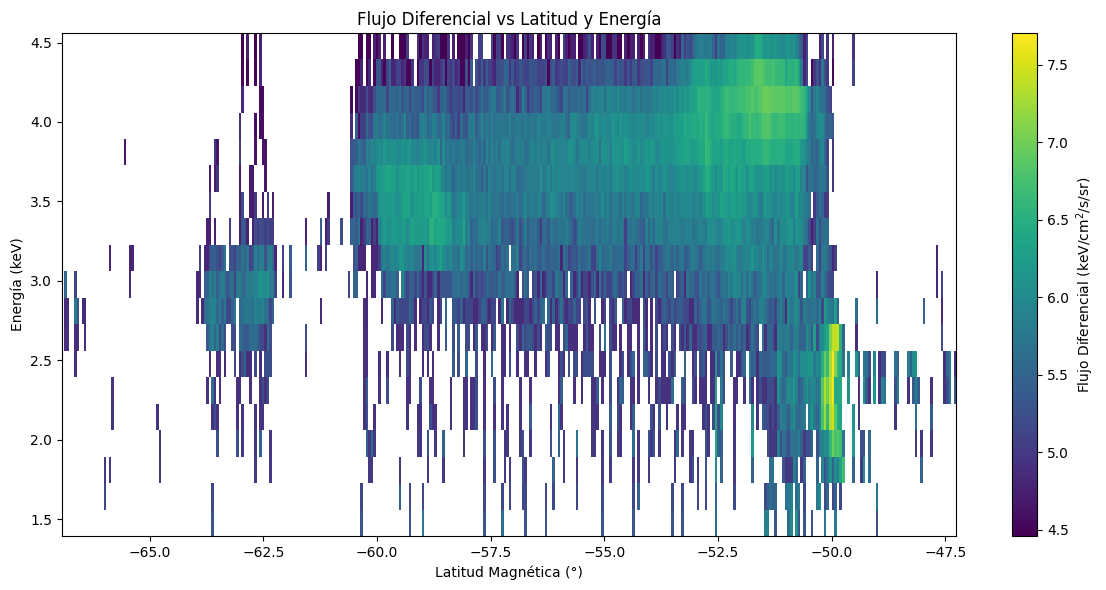

In [16]:
# Aplicamos la transformación logarítmica a los datos
log_ION_DIFF_ENERGY_FLUX,log_CHANNEL_ENERGIES=(logaritmizar([ION_DIFF_ENERGY_FLUX, CHANNEL_ENERGIES]))
Traslog_ION_DIFF_ENERGY_FLUX=np.transpose(log_ION_DIFF_ENERGY_FLUX[N1:N2])

# Graficar el flujo diferencial de iones
graficocolor(SC_GEOCENTRIC_LAT[N1:N2], log_CHANNEL_ENERGIES, Traslog_ION_DIFF_ENERGY_FLUX, 
             "Flujo Diferencial vs Latitud y Energía", "Latitud Magnética (°)", "Energía (keV)", 
             "Flujo Diferencial (keV/cm$^2$/s/sr)")

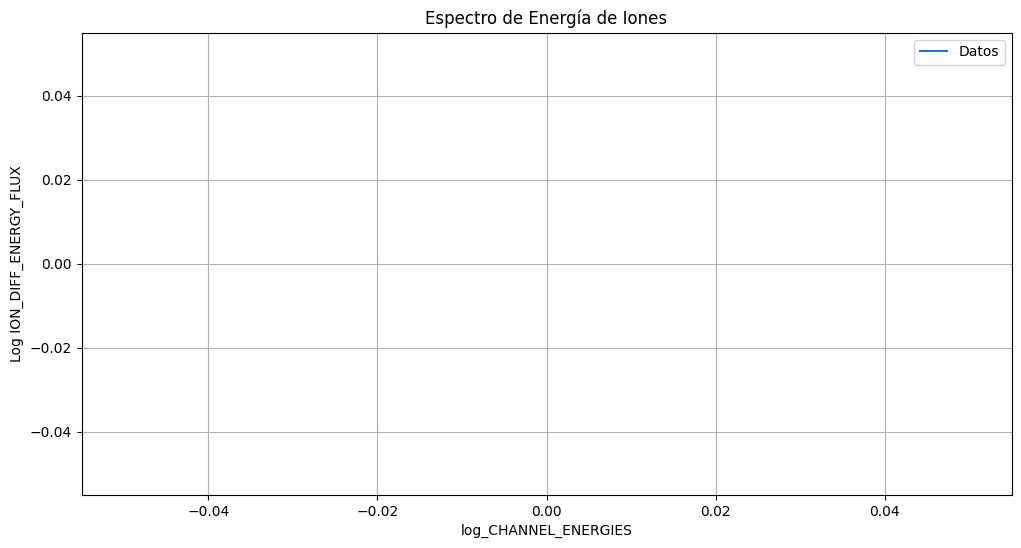

In [17]:
graficar(log_CHANNEL_ENERGIES, log_ION_DIFF_ENERGY_FLUX[NS], 'Espectro de Energía de Iones', 'log_CHANNEL_ENERGIES', 'Log ION_DIFF_ENERGY_FLUX')

In [25]:
#Calculo FLUJO TOTAL DE ENERGÍA DE IONES
# Calculamos el flujo total de energía de iones.
TOTAL_ION_ENERGY_FLUX_30_30000 = calculo_energia_total(ION_DIFF_ENERGY_FLUX[N1:N2],calculo_delta(CHANNEL_ENERGIES))

graficar(SC_GEOCENTRIC_LAT[N1:N2], TOTAL_ION_ENERGY_FLUX_30_30000, 'Flujo Total de Energía de Iones vs Latitud', 'Latitud Magnética (°)', 'Flujo Total de Energía de Iones (keV/cm$^2$/s)')

# Calculo de la latitud y tiempo en el que se presenta el máximo flujo de energía de iones (b21)
maxb2i = np.argmax(TOTAL_ION_ENERGY_FLUX_30_30000)
b2i = SC_GEOCENTRIC_LAT[N1:N2][maxb2i]
print(f"b2i se encuentra en la latitud mágnetica {b2i:.3f}° y en el tiempo {tiempo[N1:N2][maxb2i]}")

TypeError: calculo_energia_total() missing 1 required positional argument: 'bandas'

Archivo cargado: dmsp-f16_ssjs_precipitating-electrons-ions_20130531000000_20130531230000_cdaweb.cdf


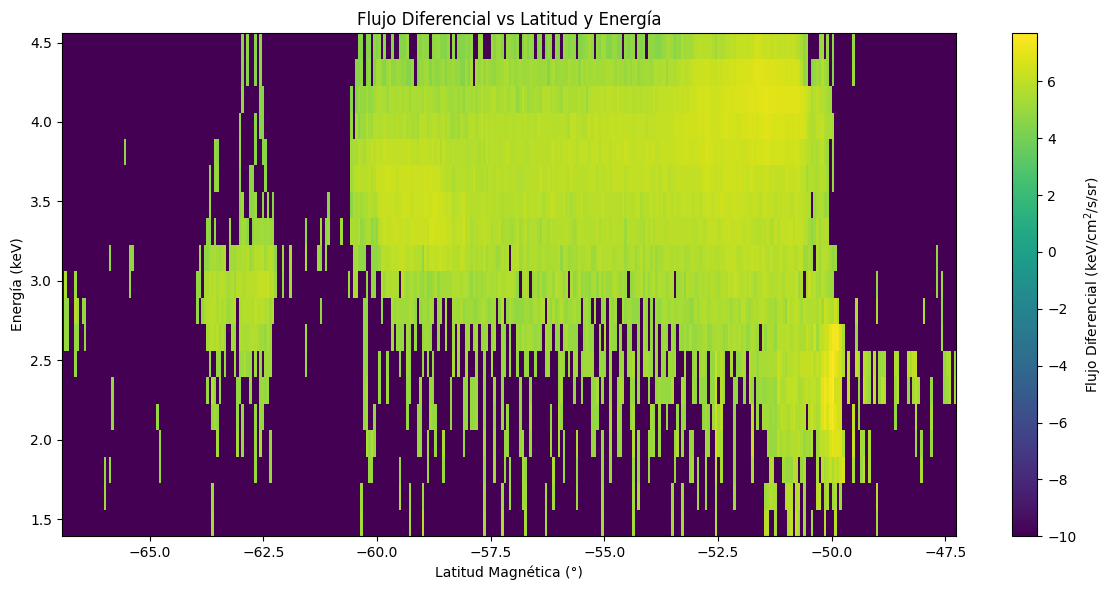

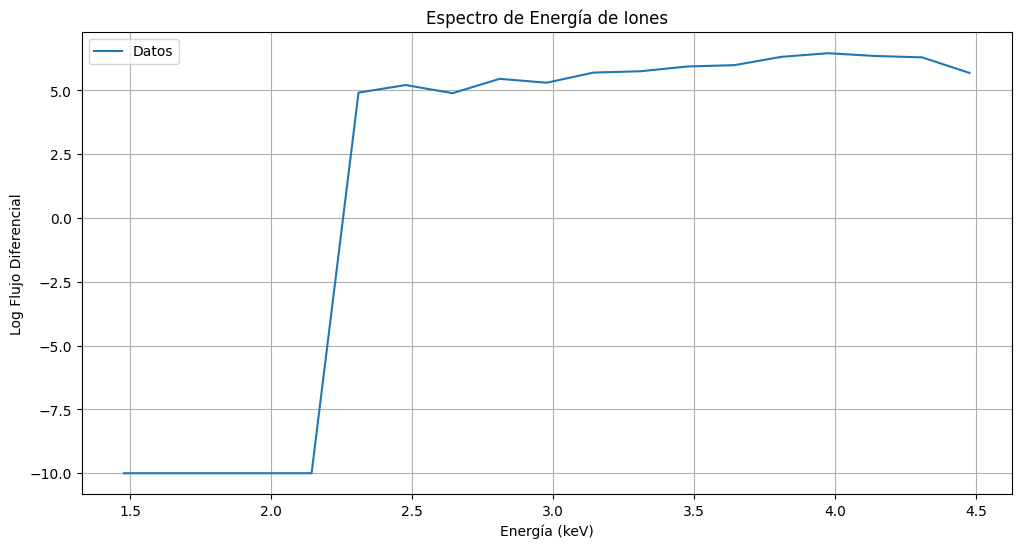

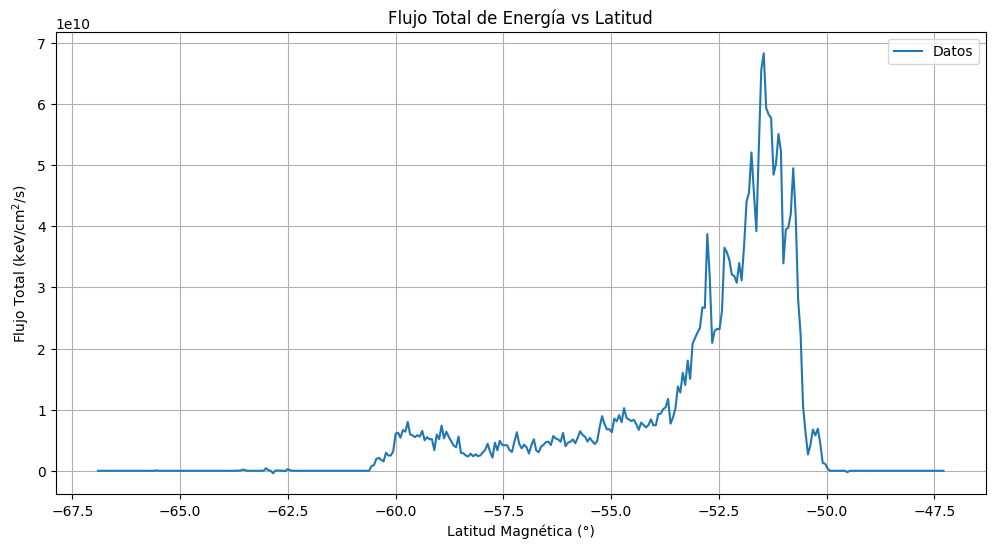

b2i se encuentra en la latitud magnética -51.457° y en el tiempo 2013-05-31T22:02:53.000000000


In [11]:
# %%
# Importación de librerías
import cdflib
import matplotlib.pyplot as plt
import numpy as np

def cargar_datos(ruta_archivo):
    """
    Carga las variables necesarias desde un archivo CDF.
    """
    try:
        cdf = cdflib.CDF(ruta_archivo)
        print(f"Archivo cargado: {ruta_archivo}")
        latitudes = cdf.varget('SC_GEOCENTRIC_LAT')
        flujo_total = cdf.varget('ION_TOTAL_ENERGY_FLUX')
        energias = cdf.varget('CHANNEL_ENERGIES')
        flujo_diferencial = cdf.varget('ION_DIFF_ENERGY_FLUX')
        tiempo = cdflib.cdfepoch.to_datetime(cdf.varget('Epoch'))
        return latitudes, flujo_total, energias, flujo_diferencial, tiempo
    except KeyError as e:
        print(f"Error: Variable no encontrada: {e}")
        return None, None, None, None, None

def logaritmizar_ajustado(array):
    """Aplica logaritmo base 10 sumando una constante pequeña a todos los datos."""
    epsilon = 1e-10
    return np.log10(array + epsilon)


def calculo_delta(energias):
    """Calcula el ancho de las bandas energéticas."""
    delta = [(e2 - e1) / 2 for e1, e2 in zip(energias[1:], energias[:-1])]
    Left = energias[1] - energias[0]  # Extremo izquierdo.
    Rigth = energias[-1] - energias[-2]  # Extremo derecho.
    delta.insert(0, Left)
    delta.append(Rigth)
    return delta

def calculo_energia_total(flujos, delta, bandas):
    """Calcula el flujo total de energía para cada punto."""
    delta_recortado = np.array(delta[:bandas])  # Selecciona solo las primeras bandas
    return [sum(flujo[:bandas] * delta_recortado) for flujo in flujos]
    


def graficocolor(latitudes, energias, flujo, titulo, xlabel, ylabel, labelcolorbar):
    """Genera un gráfico de color."""
    plt.figure(figsize=(12, 6))
    plt.pcolormesh(latitudes, energias, flujo, cmap="viridis", shading='auto')
    plt.colorbar(label=labelcolorbar)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(titulo)
    plt.tight_layout()
    plt.show()

def graficar(x, y, titulo, xlabel, ylabel):
    """Genera un gráfico de línea."""
    plt.figure(figsize=(12, 6))
    plt.plot(x, y, label='Datos')
    plt.title(titulo)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.legend()
    plt.show()

def calcular_b2i(latitudes, flujo_total):
    """Identifica la latitud b2i como el máximo flujo total.
    
    maxb2i = np.argmax(TOTAL_ION_ENERGY_FLUX_30_30000)
b2i = SC_GEOCENTRIC_LAT[N1:N2][maxb2i]
    
    """
    max_indice = np.argmax(flujo_total)
    b2i = latitudes[max_indice]
    return b2i, max_indice

def flujo_energetico_dms(filename, rango, espectro, bandas):
    """
    Proceso principal para calcular y graficar el flujo energético desde un archivo CDF.
    
    Args:
        filename (str): Ruta del archivo CDF.
        rango (tuple): Rango de índices a analizar (inicio, fin).
        espectro (int): Índice del espectro buscado.
        bandas (int): Número de bandas energéticas consideradas.
    """
    # Carga de datos
    latitudes, flujo_total, energias, flujo_diferencial, tiempo = cargar_datos(filename)
    if any(x is None for x in [latitudes, flujo_total, energias, flujo_diferencial, tiempo]):
        print("Error en la carga de datos. Revisa el archivo.")
        return

    N1, N2 = rango
    NS = espectro

    # Logaritmo de datos
    log_flujo_diferencial = logaritmizar_ajustado(flujo_diferencial)
    log_energias = logaritmizar_ajustado(energias)
    traspuesta_log_flujo = np.transpose(log_flujo_diferencial[N1:N2])

    # Gráfico de color: Flujo Diferencial
    graficocolor(
        latitudes[N1:N2], log_energias, traspuesta_log_flujo,
        "Flujo Diferencial vs Latitud y Energía", "Latitud Magnética (°)",
        "Energía (keV)", "Flujo Diferencial (keV/cm$^2$/s/sr)"
    )

    # Gráfico de espectro: Energía de Iones
    graficar(
        log_energias, log_flujo_diferencial[NS],
        "Espectro de Energía de Iones", "Energía (keV)", "Log Flujo Diferencial"
    )

    # Cálculo de flujo total de energía
    delta = calculo_delta(energias)
    total_flujo = calculo_energia_total(flujo_diferencial[N1:N2], delta, bandas)

    # Gráfico de Flujo Total
    graficar(
        latitudes[N1:N2], total_flujo,
        "Flujo Total de Energía vs Latitud", "Latitud Magnética (°)", "Flujo Total (keV/cm$^2$/s)"
    )

    # Calcular y mostrar b2i
    b2i, max_indice = calcular_b2i(latitudes[N1:N2], total_flujo)
    print(f"b2i se encuentra en la latitud magnética {b2i:.3f}° y en el tiempo {tiempo[N1:N2][max_indice]}")

# %%
# Parámetros
ruta = "dmsp-f16_ssjs_precipitating-electrons-ions_20130531000000_20130531230000_cdaweb.cdf"
rango_datos = (79300, 79650)
espectro_datos = 79400
bandas_energeticas = 6

# Llamada al proceso principal
flujo_energetico_dms(ruta, rango_datos, espectro_datos, bandas_energeticas)